In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline



Bad key "text.kerning_factor" on line 4 in
D:\Work\is\experiments\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
raster_path = "./T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [3]:
print(raster_img.shape, raster_meta)

(3, 10980, 10980) {'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32636), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5500020.0)}


In [4]:
raster_img = reshape_as_image(raster_img)

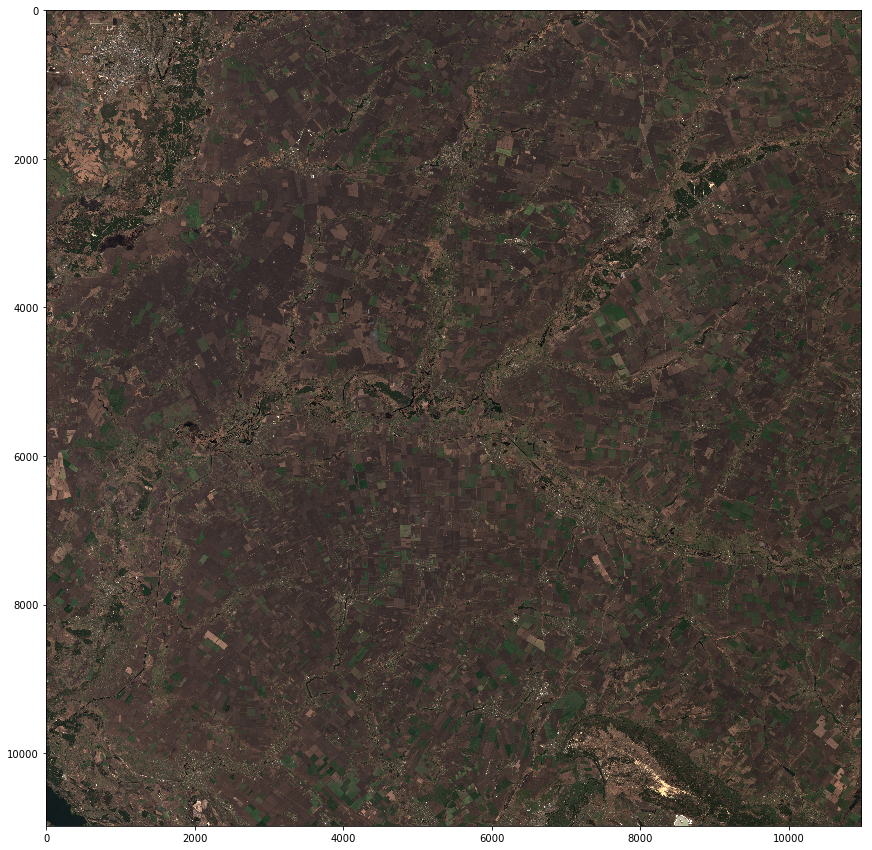

In [5]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [6]:
train_df = gpd.read_file("./masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(15)

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."
5,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60783 49.59848, 35.60736 49.59897..."
6,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.59871 49.60834, 35.59859 49.60857..."
7,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.58841 49.60416, 35.58869 49.60433..."
8,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.59142 49.60402, 35.59172 49.60377..."
9,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.58347 49.61376, 35.58220 49.61355..."


In [7]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

In [8]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        print(masked_image, out_transform)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


In [9]:
train_df = gpd.read_file("./masks/Masks_T36UXV_20190427.shp")

# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:4267'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

D:\Work\is\experiments\envs\tensorflow\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "./data"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(num) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        print(img_path)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))


./data\0.png
./data\1.png
./data\2.png
./data\3.png
./data\4.png
./data\5.png
./data\6.png
./data\7.png
./data\8.png
./data\9.png
./data\10.png
./data\11.png
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
./data\15.png
./data\16.png
./data\17.png
./data\18.png
./data\19.png
./data\20.png
./data\21.png
./data\22.png
./data\23.png
./data\24.png
./data\25.png
./data\26.png
./data\27.png
./data\28.png
./data\29.png
./data\30.png
./data\31.png
./data\32.png
./data\33.png
./data\34.png
./data\35.png
./data\36.png
./data\37.png
./data\38.png
./data\39.png
./data\40.png
./data\41.png
./data\42.png
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
./data\46.png
./data\47.png
./data\48.png
./data\49.png
./data\50.png
./data\51.png
./data\52.png
./data\53.png
./data\54.png
./data\55.png
./data\56.png
./data\57.png
./data\58.png
./data\59.png
./data\60.png
./data\61.png
./data\62.

./data\369.png
./data\370.png
./data\371.png
./data\372.png
./data\373.png
./data\374.png
./data\375.png
./data\376.png
./data\377.png
./data\378.png
./data\379.png
./data\380.png
./data\381.png
./data\382.png
./data\383.png
./data\384.png
./data\385.png
./data\386.png
./data\387.png
./data\388.png
./data\389.png
./data\390.png
./data\391.png
./data\392.png
./data\393.png
Input shapes do not overlap raster.
Input shapes do not overlap raster.
./data\396.png
./data\397.png
./data\398.png
./data\399.png
./data\400.png
./data\401.png
./data\402.png
./data\403.png
./data\404.png
./data\405.png
./data\406.png
./data\407.png
./data\408.png
./data\409.png
./data\410.png
./data\411.png
./data\412.png
./data\413.png
./data\414.png
./data\415.png
./data\416.png
./data\417.png
./data\418.png
./data\419.png
./data\420.png
./data\421.png
./data\422.png
./data\423.png
./data\424.png
./data\425.png
./data\426.png
./data\427.png
./data\428.png
./data\429.png
./data\430.png
./data\431.png
./data\432.pn

Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
./data\892.png
./data\893.png
./data\894.png
./data\895.png
./data\896.png
./data\897.png
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shapes do not overlap raster.
Input shap

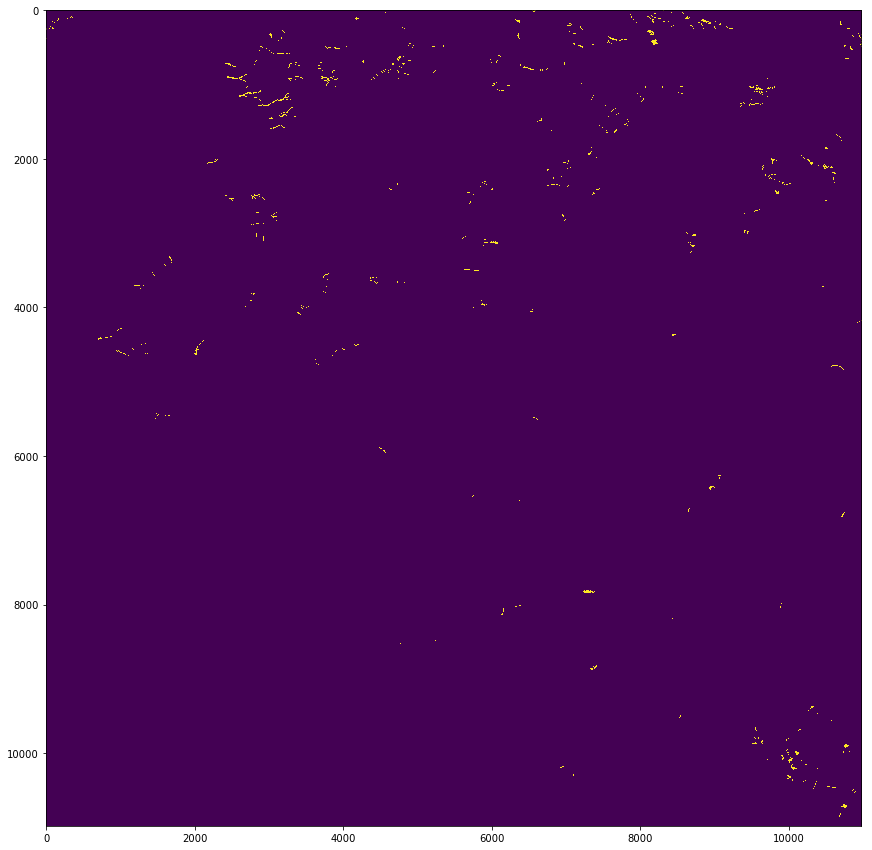

In [11]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)


In [12]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("./T36UXV_20200406T083559_TCI_10m_mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

# Image preparation

### raster_img to tensor

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

full_tensor = torch.tensor(raster_img)

In [14]:
full_tensor.shape

torch.Size([10980, 10980, 3])

In [15]:
mask.shape

(10980, 10980)

In [16]:
full_tensor_reshaped = full_tensor.permute(2, 0, 1)

In [17]:
randomTransformation = torchvision.transforms.RandomCrop(500)
test_img = randomTransformation(full_tensor_reshaped)

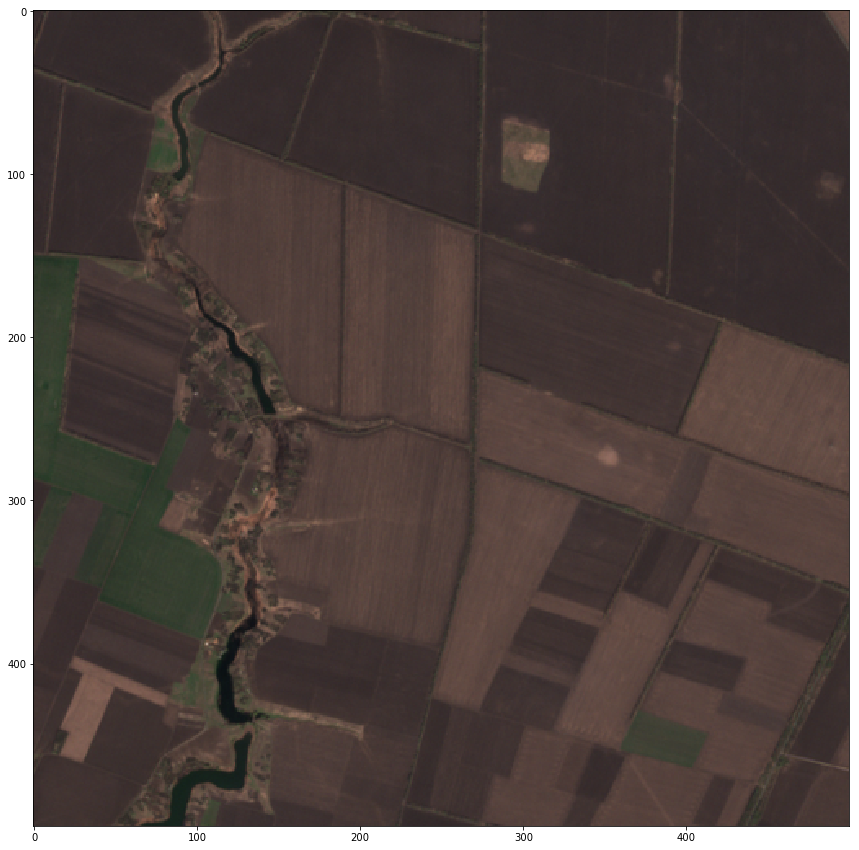

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(test_img.permute(1, 2, 0))
plt.show()

In [19]:
# Dataset mapper
class MapDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_input, dataset_output, transformation = None):
        self.dataset_input = torch.tensor(dataset_input, dtype=torch.float32)
        self.dataset_output = torch.tensor(dataset_output, dtype=torch.float32)
        
        self.transformation = transformation
        
        self.window_side_size = 88
        self.side_len = len(self.dataset_input[1]) // self.window_side_size
        self.map_normalization = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # change params according to the dataset
    def __getitem__(self, index):
        if(index < self.__len__()):
            i = index % self.side_len
            j = index // self.side_len

            if self.transformation:
                return (
                    self.transformation(
                        self.map_normalization(
                            torchvision.transforms.functional.crop(
                                self.dataset_input,
                                j*self.window_side_size,
                                i*self.window_side_size,
                                self.window_side_size,
                                self.window_side_size
                            )
                        )
                    ),
                    self.transformation(
                        torchvision.transforms.functional.crop(
                            self.dataset_output,
                            j*self.window_side_size,
                            i*self.window_side_size,
                            self.window_side_size,
                            self.window_side_size
                        )
                    )
                )
            else:
                return (
                    self.map_normalization(
                        torchvision.transforms.functional.crop(
                            self.dataset_input,
                            j*self.window_side_size,
                            i*self.window_side_size,
                            self.window_side_size,
                            self.window_side_size
                        )
                    ),
                    torchvision.transforms.functional.crop(
                        self.dataset_output,
                        j*self.window_side_size,
                        i*self.window_side_size,
                        self.window_side_size,
                        self.window_side_size
                    )
                )

        else:
            return False

    def __len__(self):
        return self.side_len*self.side_len

In [20]:
full_dataset = MapDataset(
    full_tensor_reshaped,
    torch.tensor(mask)
)


D:\Work\is\experiments\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
D:\Work\is\experiments\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [21]:
validation_split = 0.3
full_set_len = len(full_dataset)
train_set_len = int(full_set_len*validation_split)

train_set, val_set = torch.utils.data.random_split(
    full_dataset,
    [
        train_set_len,
        full_set_len-train_set_len
    ]
)



In [22]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size
)

In [23]:
len(train_loader)

144

In [24]:
# generate augmented dataset
def train_augmentation_generator(train_set, train_transforms_queue):
    train_set_buffer = train_set
    for transrorm_iteration in range(len(train_transforms_queue)):
        print(len(train_set_buffer))
        train_set_buffer = torch.utils.data.ConcatDataset([
            train_set_buffer, MapDataset(train_set, train_transforms_queue[transrorm_iteration])
        ])
    return train_set_buffer


In [25]:
#plt.figure(figsize=(10,10))
#plt.imshow(full_output_dataset.__getitem__(0))
#plt.show()

In [26]:
#plt.figure(figsize=(10,10))
#plt.imshow(test.__getitem__(0).permute(1, 2, 0))
#plt.show()

In [27]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x, x3)
        #x = self.up3(x, x2)
        #x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [28]:
first_net = UNet(
    n_channels=3,
    n_classes=1
)
sum(p.numel() for p in first_net.parameters())

12434753

In [29]:
device = "cuda"
num_of_epoch = 3
criterion = nn.BCELoss()

model_to_train = first_net

optimizer = torch.optim.SGD(model_to_train.parameters(), lr=0.01, momentum=0.9)

model_to_train.to(device)
criterion = criterion.to(device)
num_of_train_batches = len(train_loader)
# training
for epoch in range(num_of_epoch):
    model_to_train.train()

    correct = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)  # to GPU

        optimizer.zero_grad()  # zero calculated gradient
        outputs = model_to_train(inputs)
        labels = labels.unsqueeze(1)
        print(inputs.shape, outputs.shape, labels.shape)
        loss = criterion(outputs, labels) # calculate loss value
        loss.backward()  # calculate gradients
        optimizer.step()  # update params

        running_loss += loss.item()
        if i % 20 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))

    avg_loss = running_loss/num_of_train_batches # calculate avarage loss for each epoch
    #avg_acc = 100*correct/(num_of_train_batches*batch_size) # calculate accuracy loss for each epoch

    print("Epoch (avg loss & accuracy & val accuracy): %d [%.3f, %.3f]" % (epoch + 1, avg_loss, 0))

print('Finished Training')

RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[32, 768, 22, 22] to have 1024 channels, but got 768 channels instead

In [ ]:
# loss fucntion is a pixel-wise cross entropy loss
# learn about dice loss
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    # optional part
    pred = pred.unsqueeze(0).unsqueeze(0)
    target = target.unsqueeze(0).unsqueeze(0)
    print(pred.shape, target.shape)
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample') # check if upsample arg is set correctly, continue
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)): #proces items in reverse order
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out
